In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from dipy.core.geometry import vec2vec_rotmat

from disimpy import simulations, gradients

In [2]:
# Define simulation parameters

n_s = int(1e4) # Number of random walkers
n_t = int(1e3) # Number of time points
bs = np.linspace(0, 3e9, 100) # b-values
diffusivity = 2e-9 # In units of m^2/s

# Define gradient array

gradient_file = 'disimpy/tests/example_gradient.txt'
gradient = np.loadtxt(gradient_file)[np.newaxis,:,:] # Load gradient info
T = 80e-3 # Gradient duration
dt = T/(gradient.shape[1]-1) # Timestep duration
gradient = np.concatenate([gradient for i in range(len(bs))], axis=0)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient[gradient > 1e-4] = 1
gradient[gradient < -1e-4] = -1
gradient = gradients.set_b(gradient, dt, bs)
delta = np.sum(gradient[-1,:,:] > 0)*dt
DELTA = np.min(np.where(gradient[-1,:,0]<0))*dt
max_Gs = np.max(np.linalg.norm(gradient, axis=2), axis=0)

In [3]:
# Add 6 more directions to use in tests

phi = (1 + np.sqrt(5))/2
directions = np.array([[0, 1, phi],
                       [0, 1, -phi],
                       [1, phi, 0],
                       [1, -phi, 0],
                       [phi, 0, 1],
                       [phi, 0, -1]])/np.linalg.norm([0,1,-phi])
base_gradient = np.copy(gradient)
for direction in directions:
    Rs = [vec2vec_rotmat(np.array([1,0,0]), direction) for _ in bs]
    gradient = np.concatenate((gradient, gradients.rotate_gradient(base_gradient, Rs)), axis=0)
bvecs = np.concatenate((np.vstack([np.array([1,0,0]) for i in range(n_s)]),
                        np.vstack([directions[0] for i in range(n_s)]),
                        np.vstack([directions[1] for i in range(n_s)]),
                        np.vstack([directions[2] for i in range(n_s)]),
                        np.vstack([directions[3] for i in range(n_s)]),
                        np.vstack([directions[4] for i in range(n_s)]),
                        np.vstack([directions[5] for i in range(n_s)])), 
                       axis=0)
max_Gs = np.concatenate(([max_Gs for i in range(7)]))

In [4]:
# To compare these results to results acquired with Camino, define a scheme file

# VERSION: STEJSKALTANNER
# x_1 y_1 z_1 |G_1| DELTA_1 delta_1 TE_1
# x_2 y_2 z_2 |G_2| DELTA_2 delta_2 TE_2

with open('disimpy/tests/camino/default.scheme', 'w+') as f:
    f.write('VERSION: STEJSKALTANNER')
for i, G in enumerate(max_Gs):
    with open('disimpy/tests/camino/default.scheme', 'a') as f:
        f.write('\n%s %s %s %s %s %s %s' %(bvecs[i,0], bvecs[i,1], bvecs[i,2], G, DELTA, delta, 81e-3))
        
        
# The following commands were used in generating the results in tests/camino

datasynth -walkers 10000 -tmax 1000 -voxels 1 -p 0.0 -diffusivity 2E-9 -substrate empty -schemefile default.scheme > free.bfloat
datasynth -walkers 10000 -tmax 1000 -voxels 1 -p 0.0 -diffusivity 2E-9 -initial intra -substrate cylinder -cylinderrad 2E-6 -cylindersep 4.1E-6 -schemefile default.scheme > cyl_r2um.bfloat
datasynth -walkers 10000 -tmax 1000 -voxels 1 -p 0.0 -diffusivity 2E-9 -initial intra -substrate cylinder -cylinderrad 4E-6 -cylindersep 8.2E-6 -schemefile default.scheme > cyl_r4um.bfloat
datasynth -walkers 10000 -tmax 1000 -voxels 1 -p 0.0 -diffusivity 2E-9 -initial intra -substrate cylinder -cylinderrad 6E-6 -cylindersep 12.3E-6 -schemefile default.scheme > cyl_r6um.bfloat
datasynth -walkers 10000 -tmax 1000 -voxels 1 -p 0.0 -diffusivity 2E-9 -initial intra -substrate cylinder -cylinderrad 8E-6 -cylindersep 16.4E-6 -schemefile default.scheme > cyl_r8um.bfloat
datasynth -walkers 10000 -tmax 1000 -voxels 1 -p 0.0 -diffusivity 2E-9 -initial intra -substrate cylinder -cylinderrad 10E-6 -cylindersep 20.5E-6 -schemefile default.scheme > cyl_r10um.bfloat


# Load Camino results

c_free = np.fromfile('disimpy/tests/camino/free.bfloat', dtype='>f')
c_r2 = np.fromfile('disimpy/tests/camino/cyl_r2um.bfloat', dtype='>f')
c_r4 = np.fromfile('disimpy/tests/camino/cyl_r4um.bfloat', dtype='>f')
c_r6 = np.fromfile('disimpy/tests/camino/cyl_r6um.bfloat', dtype='>f')
c_r8 = np.fromfile('disimpy/tests/camino/cyl_r8um.bfloat', dtype='>f')
c_r10 = np.fromfile('disimpy/tests/camino/cyl_r10um.bfloat', dtype='>f')

In [21]:
# Run simulation

substrate = {'type' : 'cylinder',
             'orientation' : np.array([0, 0, 1]),
             'radius' : 2e-6}
s_r2 = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)

substrate['radius'] = 4e-6
s_r4 = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)

substrate['radius'] = 6e-6
s_r6 = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)

substrate['radius'] = 8e-6
s_r8 = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)

substrate['radius'] = 10e-6
s_r10 = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


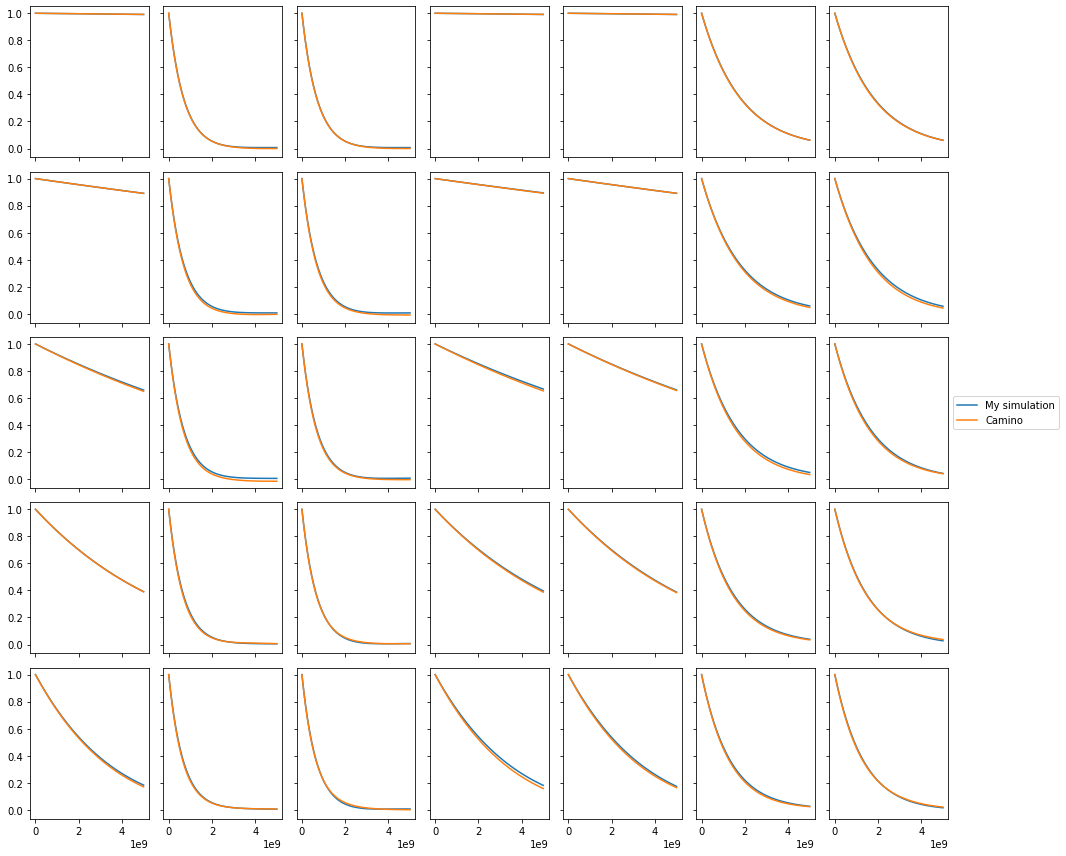

In [26]:
# Show comparison figures over all directions

fig, ax = plt.subplots(5, 7, figsize=(15,12), sharex=True, sharey=True)
for i in range(7):
    ax[0,i].plot(bs, s_r2[i*100:(i+1)*100]/n_s)
    ax[0,i].plot(np.linspace(0,5e9,100), c_r2[i*100:(i+1)*100]/n_s)
    ax[1,i].plot(bs, s_r4[i*100:(i+1)*100]/n_s)
    ax[1,i].plot(np.linspace(0,5e9,100), c_r4[i*1000:(i+1)*100]/n_s)
    ax[2,i].plot(bs, s_r6[i*100:(i+1)*100]/n_s)
    ax[2,i].plot(np.linspace(0,5e9,100), c_r6[i*100:(i+1)*100]/n_s)
    ax[3,i].plot(bs, s_r8[i*100:(i+1)*100]/n_s)
    ax[3,i].plot(np.linspace(0,5e9,100), c_r8[i*100:(i+1)*100]/n_s)
    ax[4,i].plot(bs, s_r10[i*100:(i+1)*100]/n_s)
    ax[4,i].plot(np.linspace(0,5e9,100), c_r10[i*100:(i+1)*100]/n_s)
box = ax[0,2].get_position()
ax[2,6].legend(['My simulation', 'Camino'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
